In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
features = pd.read_pickle('Liar-Liar-FS-nodup.pkl')
features.fillna(0,inplace=True)

In [3]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10223 entries, 0 to 10222
Data columns (total 28 columns):
TF                                      10223 non-null float64
Bigram TF                               10223 non-null float64
No. of Stop_words                       10223 non-null float64
Out of Context                          10223 non-null float64
Arts, Culture, Entertainment, Sports    10223 non-null float64
Conspiracy                              10223 non-null float64
Business and Industrial                 10223 non-null float64
economy, business and finance           10223 non-null float64
Religion and belief                     10223 non-null float64
Law, Government and Politics            10223 non-null float64
Education                               10223 non-null float64
Technology and Computing                10223 non-null float64
Science                                 10223 non-null float64
Sixltr                                  10223 non-null float64
conj     

In [4]:
df= pd.read_pickle('Liar-Liar-dup.pkl')
list(df.columns)

['Statement ID',
 'Label',
 'Statement',
 'Subject(s)',
 'Speaker',
 'Speakers Job Title',
 'State Info.',
 'Party Affiliation',
 'Barely True Counts',
 'False Counts',
 'Half True Counts',
 'Mostly True Counts',
 'Pants on fire counts',
 'Context',
 'Grammatical errors',
 'pos_tag',
 'clean_text',
 'TF',
 'TF_final',
 'out_of_context_terms',
 'out_context_final',
 'Textrazor_category',
 'Textrazor_topic',
 'Topics_category',
 'Topics_topic',
 'score_category',
 'score_topic',
 'category_score_final',
 'category_list_final',
 'topic_score_final',
 'topic_list_final',
 'formula 1',
 'formula 2',
 'bigram TF',
 'bigram TF final',
 'No. of stop_words',
 'arts, culture and entertainment',
 'Conspiracy',
 'crime, law and justice',
 'Criticism of journalism',
 'Advertising video on demand',
 'computing and information technology',
 'agriculture',
 'energy and resource',
 'economy, business and finance',
 'Harassment',
 'Cyberspace',
 'religion and belief',
 'Politics and technology',
 'Socia

In [5]:
print(len(df))
print(len(features))

10223
10223


In [6]:
df.head()

,Statement ID,Label,Statement,Subject(s),Speaker,Speakers Job Title,State Info.,Party Affiliation,Barely True Counts,False Counts,...,NORP,CARDINAL,LAW,PERCENT,TIME,LOC,PRODUCT,QUANTITY,WORK_OF_ART,LANGUAGE
0,2635.json,FALSE,Says the Annie List political group supports t...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10540.json,half-true,When did the decline of coal start? Buses admi...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1123.json,FALSE,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
dict = {'FALSE' : 0, 'TRUE' : 1, 'pants-fire' : 0, 'half-true': 1, 'mostly-true':1, 'barely-true': 0}
y= df.loc[:,['Label']]
y=y.replace({"Label": dict})

In [8]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
tokenizer= Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=" ")

sentences_train, sentences_test, y_train, y_test = train_test_split(
       df['Statement'].values, y.iloc[:,0].values, test_size=0.20, random_state=1000)

tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

Using TensorFlow backend.


In [9]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

10896


In [10]:
from statistics import mean 
train_lengths= [len(x) for x in X_train]
mean(train_lengths)

18.31217901687454

In [11]:
from keras.preprocessing.sequence import pad_sequences
maxlen = 30
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
from keras.models import Sequential
from keras import layers
from keras.models import Model
from keras.layers import  Activation, Dense, Dropout, Input, Embedding, Bidirectional, TimeDistributed, Flatten
from keras.layers.recurrent import GRU, SimpleRNN, LSTM
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
embedding_dim = 50

def Lstm():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(vocab_size,64,input_length=maxlen)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def RNN():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(vocab_size,64,input_length=maxlen)(inputs)
    layer = SimpleRNN(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def Gru():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(vocab_size,64,input_length=maxlen)(inputs)
    layer = GRU(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

def BiLSTM():
    inputs = Input(name='inputs',shape=[maxlen])
    layer = Embedding(vocab_size,64,input_length=maxlen)(inputs)
    layer =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(layer)
    layer = TimeDistributed(Dense(100,activation='relu'))(layer)
    layer = Flatten()(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [13]:
#CREATE MODEL AND TRAIN
print("This is an LSTM Model: ")
lstm1 = Lstm()
lstm1.summary()
lstm1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
lstm1.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = lstm1.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = lstm1.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an LSTM Model: 
Instructions for updating:
Colocations handled automatically by placer.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_____________________________

In [14]:
#CREATE MODEL AND TRAIN
print("This is an LSTM Model: ")
lstm2 = Lstm()
lstm2.summary()
lstm2.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
lstm2.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = lstm2.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = lstm2.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an LSTM Model: 
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None,

In [15]:
#CREATE MODEL AND TRAIN
print("This is an LSTM Model: ")
lstm3 = Lstm()
lstm3.summary()
lstm3.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
lstm3.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = lstm3.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = lstm3.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an LSTM Model: 
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_5 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None,

In [16]:
#CREATE MODEL AND TRAIN
print("This is an RNN Model: ")
rnn1 = RNN()
rnn1.summary()
rnn1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
rnn1.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = rnn1.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = rnn1.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an RNN Model: 
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_7 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 

In [17]:
#CREATE MODEL AND TRAIN
print("This is an RNN Model: ")
rnn2 = RNN()
rnn2.summary()
rnn2.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
rnn2.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = rnn2.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = rnn2.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an RNN Model: 
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_9 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 

In [18]:
#CREATE MODEL AND TRAIN
print("This is an RNN Model: ")
rnn3 = RNN()
rnn3.summary()
rnn3.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
rnn3.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = rnn3.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = rnn3.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an RNN Model: 
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_11 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 

In [19]:
#CREATE MODEL AND TRAIN
print("This is an GRU Model: ")
gru1 = Gru()
gru1.summary()
gru1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
gru1.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = gru1.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = gru1.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an GRU Model: 
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 30, 64)            697344    
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                24768     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_13 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 

In [28]:
#CREATE MODEL AND TRAIN
print("This is an GRU Model: ")
gru2 = Gru()
gru2.summary()
gru2.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
gru2.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = gru2.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = gru2.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an GRU Model: 
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 30, 64)            697344    
_________________________________________________________________
gru_5 (GRU)                  (None, 64)                24768     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_27 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None,

In [32]:
#CREATE MODEL AND TRAIN
print("This is an GRU Model: ")
gru3 = Gru()
gru3.summary()
gru3.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
gru3.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = gru3.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = gru3.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an GRU Model: 
Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_18 (Embedding)     (None, 30, 64)            697344    
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24768     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_35 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None,

In [22]:
#CREATE MODEL AND TRAIN
print("This is an Bi-Directional LSTM Model: ")
BiLSTM1 = BiLSTM()
BiLSTM1.summary()
BiLSTM1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
BiLSTM1.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = BiLSTM1.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = BiLSTM1.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an Bi-Directional LSTM Model: 
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 30, 64)            697344    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 200)           132000    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 100)           20100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 3000)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               768256    
_________________________________________________________________
activation_19 (Acti

In [23]:
#CREATE MODEL AND TRAIN
print("This is an Bi-Directional LSTM Model: ")
BiLSTM2 = BiLSTM()
BiLSTM2.summary()
BiLSTM2.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
BiLSTM2.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = BiLSTM2.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = BiLSTM2.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an Bi-Directional LSTM Model: 
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 30, 64)            697344    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 200)           132000    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 30, 100)           20100     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3000)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               768256    
_________________________________________________________________
activation_21 (Acti

In [24]:
#CREATE MODEL AND TRAIN
print("This is an Bi-Directional LSTM Model: ")
BiLSTM3 = BiLSTM()
BiLSTM3.summary()
BiLSTM3.compile(loss='binary_crossentropy',optimizer=SGD(),metrics=['accuracy'])

from keras.callbacks import EarlyStopping
BiLSTM3.fit(X_train,y_train,batch_size=32,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

accr = BiLSTM3.evaluate(X_test,y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))




yhat_probs = BiLSTM3.predict(X_test, verbose=0)
yhat_classes=(yhat_probs>0.5)*(np.ones(yhat_probs.shape))

#METRICS
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes, average='weighted')
print(' Weighted Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='micro')
print(' Micro Precision: %f' % precision)
precision = precision_score(y_test, yhat_classes, average='macro')
print(' Macro Precision: %f' % precision)

# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes, average ='weighted')
print('Weighted Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='micro')
print('Micro Recall: %f' % recall)
recall = recall_score(y_test, yhat_classes, average ='macro')
print('Macro Recall: %f' % recall)

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)
 
# kappa
kappa = cohen_kappa_score(y_test, yhat_classes)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)

This is an Bi-Directional LSTM Model: 
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 30)                0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 30, 64)            697344    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 30, 200)           132000    
_________________________________________________________________
time_distributed_3 (TimeDist (None, 30, 100)           20100     
_________________________________________________________________
flatten_3 (Flatten)          (None, 3000)              0         
_________________________________________________________________
FC1 (Dense)                  (None, 256)               768256    
_________________________________________________________________
activation_23 (Acti

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


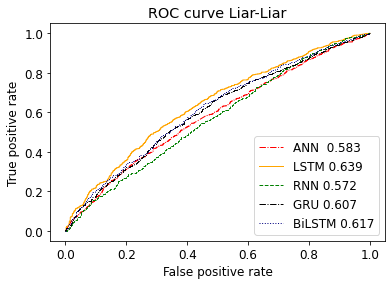

In [49]:
from sklearn import  metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
import pickle
#LSTM
y_pred_lstm = lstm1.predict(X_test)
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_test, y_pred_lstm)
auc_lstm = auc(fpr_lstm, tpr_lstm)
#RNN
y_pred_rnn = rnn1.predict(X_test)
fpr_rnn, tpr_rnn, thresholds_rnn = roc_curve(y_test, y_pred_rnn)
auc_rnn = auc(fpr_rnn, tpr_rnn)
#GRU
y_pred_gru = gru1.predict(X_test)
fpr_gru, tpr_gru, thresholds_gru = roc_curve(y_test, y_pred_gru)
auc_gru = auc(fpr_gru, tpr_gru)
#Bi-LSTM
y_pred_BiLSTM = BiLSTM2.predict(X_test)
fpr_BiLSTM, tpr_BiLSTM, thresholds_BiLSTM = roc_curve(y_test, y_pred_BiLSTM)
auc_BiLSTM = auc(fpr_BiLSTM, tpr_BiLSTM)

# plt.figure(1)
fig=pickle.load(open('ROC_Liar-Liar.pickle', 'rb'))
# ax = plt.subplot(111)
plt.plot(fpr_lstm, tpr_lstm, label='LSTM {:.3f}'.format(auc_lstm), color='orange', linestyle='-', linewidth=1)
plt.plot(fpr_rnn, tpr_rnn, label='RNN {:.3f}'.format(auc_rnn), color='green', linestyle='--', linewidth=1)
plt.plot(fpr_gru, tpr_gru, label='GRU {:.3f}'.format(auc_gru), color='black', linestyle='-.', linewidth=1)
plt.plot(fpr_BiLSTM, tpr_BiLSTM, label='BiLSTM {:.3f}'.format(auc_BiLSTM), color='navy', linestyle=':', linewidth=1)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve Liar-Liar')
plt.legend(loc='best')
# pickle.dump(fig, open('ROC_Liar-Liar.pickle', 'wb'))
plt.savefig('ROC_Liar-Liar.eps')
plt.show()



In [8]:
dict = {'FALSE' : 0, 'TRUE' : 1, 'pants-fire' : 0, 'half-true': 1, 'mostly-true':1, 'barely-true': 0}
df['CombinedLabel']= df.loc[:,['Label']]
df['CombinedLabel']=df['CombinedLabel'].replace(dict)

In [9]:
df['CombinedLabel']

0        0
1        1
2        1
3        0
4        1
        ..
10218    1
10219    1
10220    1
10221    0
10222    0
Name: CombinedLabel, Length: 10223, dtype: int64

In [10]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
stop_words=set(stopwords.words('english'))
lemma=WordNetLemmatizer()
stemmer= PorterStemmer()

def clean_review(review_text):
    review_text=re.sub(r'http\S+', ' ',review_text) #Removing url
    review_text=re.sub(r'[^a-zA-Z]', ' ',review_text) #Removing Numbers and Punctuation
    review_text= str(review_text).lower()   #Lower casing the sentence
    review_text= word_tokenize(review_text)    #Tokenization
    review_text = [item for item in review_text if item not in stop_words]  # Removing stop_words
    review_text = [lemma.lemmatize(word=w, pos= 'v') for w in review_text]       #Lemmatization
    review_text= [i for i in review_text if len(i)>3]     #Removing small length words
    review_text = ' '.join(review_text)     #converting back to string
    return review_text
    

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


4479


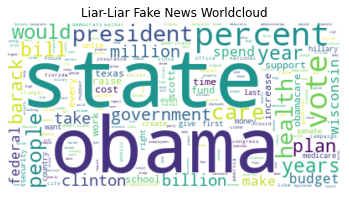

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df['CleanReview']=df['Statement'].apply(clean_review)
text=""
print(len(df[df['CombinedLabel']==0]))
for sentence in list(df[df['CombinedLabel']==0]['CleanReview']):
    text= text + ' ' + sentence
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
# text=text.lower()
# for i in filters:
#     text=text.replace(i, ' ')
text_tokens = word_tokenize(text)
# tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

wordfreq = {}
for word in text_tokens:
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    


wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=wordfreq)
plt.figure(figsize=(6,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Liar-Liar Fake News Worldcloud')
fig = plt.gcf()
fig.savefig('liar-liar-Fake.eps',transparent=False, bbox_inches='tight', dpi=300)
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adith\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


5744


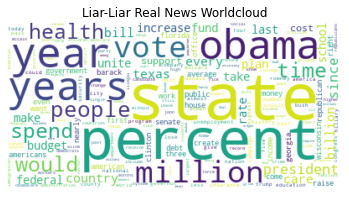

In [12]:
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud

df['CleanReview']=df['Statement'].apply(clean_review)
text=""
print(len(df[df['CombinedLabel']==1]))
for sentence in list(df[df['CombinedLabel']==1]['CleanReview']):
    text= text + ' ' + sentence
# filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
# text=text.lower()
# for i in filters:
#     text=text.replace(i, ' ')
text_tokens = word_tokenize(text)
# tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

wordfreq = {}
for word in text_tokens:
    wordfreq[word] = wordfreq.setdefault(word, 0) + 1
    


wordcloud = WordCloud(background_color='white')
wordcloud.generate_from_frequencies(frequencies=wordfreq)
plt.figure(figsize=(6,4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title('Liar-Liar Real News Worldcloud')
fig = plt.gcf()
fig.savefig('liar-liar-Real.eps',transparent=False, bbox_inches='tight', dpi=300)
plt.show()

In [39]:
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter
df['CleanReview']=df['Statement'].apply(clean_review)
sentences = [i for i in df.CleanReview]
vocab = set(word_tokenize(' '.join(sentences)))
print('Vocabulary:\n',vocab,'\n')
print('Vocabulary:\n',len(vocab),'\n')
token_sent_list = [word_tokenize(sen) for sen in sentences]
print('Each sentence in token form:\n',token_sent_list[:10],'\n')

co_occ = {ii:Counter({jj:0 for jj in vocab if jj!=ii}) for ii in vocab}
k=2

for sen in token_sent_list:
    for ii in range(len(sen)):
        if ii < k:
            c = Counter(sen[0:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        elif ii > len(sen)-(k+1):
            c = Counter(sen[ii-k::])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c
        else:
            c = Counter(sen[ii-k:ii+k+1])
            del c[sen[ii]]
            co_occ[sen[ii]] = co_occ[sen[ii]] + c



Vocabulary:
 {'kind', 'principles', 'endorsers', 'amniocentesis', 'outlaw', 'trait', 'communicate', 'puerto', 'stratosphere', 'prestigious', 'adoptions', 'hale', 'carlos', 'extension', 'revelations', 'atms', 'brainwash', 'offend', 'middle', 'medicares', 'stan', 'meatpacking', 'extortion', 'dairyland', 'mismanagement', 'odinga', 'appalachian', 'tennessee', 'afghan', 'drain', 'advancement', 'forensic', 'industrial', 'oyster', 'hayne', 'factor', 'temporary', 'impair', 'stencil', 'onto', 'cahoots', 'scion', 'automotive', 'sheriff', 'guardians', 'vacant', 'inspection', 'though', 'assassination', 'trash', 'mystify', 'loraine', 'puckett', 'indicators', 'auschwitz', 'recidivism', 'fair', 'vapor', 'ebay', 'expressly', 'okay', 'relatively', 'afloat', 'oshaughnessy', 'batteries', 'auto', 'tillis', 'discipline', 'cleanup', 'towards', 'cleanse', 'inadequate', 'roosevelt', 'adult', 'curb', 'richmond', 'artificial', 'racetrack', 'burger', 'commend', 'roundtable', 'systems', 'vest', 'hospitality', 'hi

Each sentence in token form:
 [['annie', 'list', 'political', 'group', 'support', 'third', 'trimester', 'abortions', 'demand'], ['decline', 'coal', 'start', 'administration'], ['hillary', 'clinton', 'agree', 'john', 'mccain', 'vote', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], ['health', 'care', 'reform', 'legislation', 'likely', 'mandate', 'free', 'change', 'surgeries'], ['economic', 'turnaround', 'start', 'term'], ['chicago', 'bear', 'start', 'quarterback', 'last', 'years', 'total', 'number', 'tenure', 'faculty', 'fire', 'last', 'decades'], ['dunn', 'live', 'district', 'represent', 'years'], ['person', 'stage', 'work', 'actively', 'last', 'year', 'pass', 'along', 'russ', 'feingold', 'toughest', 'ethics', 'reform', 'since', 'watergate'], ['however', 'take', 'million', 'oregon', 'lottery', 'fund', 'port', 'newport', 'eventually', 'land', 'noaa', 'marine', 'operations', 'center', 'pacific'], ['primary', 'opponents', 'glenn', 'roman', 'latham', 'cast', 'compromise', 'vote', 'c

In [44]:
print(co_occ['pass'])

Counter({'bill': 29, 'legislation': 14, 'senate': 13, 'stimulus': 12, 'state': 11, 'obama': 10, 'budget': 9, 'percent': 8, 'since': 8, 'vote': 8, 'congress': 8, 'laws': 7, 'obamacare': 7, 'barack': 6, 'years': 6, 'care': 6, 'last': 5, 'year': 5, 'never': 5, 'legislature': 5, 'increase': 5, 'texas': 4, 'house': 4, 'democrats': 4, 'help': 4, 'three': 4, 'health': 4, 'stop': 4, 'super': 4, 'financial': 4, 'bipartisan': 3, 'measure': 3, 'rate': 3, 'would': 3, 'reform': 3, 'immigration': 3, 'medicare': 3, 'amendment': 3, 'without': 3, 'actually': 3, 'lobbyists': 3, 'stand': 3, 'grind': 3, 'first': 3, 'call': 3, 'take': 3, 'washington': 2, 'massachusetts': 2, 'dodd': 2, 'frank': 2, 'representatives': 2, 'resolution': 2, 'eight': 2, 'want': 2, 'transportation': 2, 'referendum': 2, 'voters': 2, 'together': 2, 'move': 2, 'plan': 2, 'program': 2, 'republican': 2, 'balance': 2, 'live': 2, 'create': 2, 'work': 2, 'chamber': 2, 'write': 2, 'billion': 2, 'proposition': 2, 'school': 2, 'georgia': 2, 

In [50]:
# Having final matrix in dict form lets you convert it to different python data structures
co_occ = {ii: dict(co_occ[ii]) for ii in vocab}
display(co_occ)

TypeError: 'dict' object is not callable

In [47]:
from nltk.tokenize import word_tokenize
from itertools import combinations
from collections import Counter
df['CleanReview']=df['Statement'].apply(clean_review)
sentences = [i for i in df.CleanReview]
vocab = set(word_tokenize(' '.join(sentences)))
# print('Vocabulary:\n',vocab,'\n')
print('Vocabulary:\n',len(vocab),'\n')
token_sent_list = [word_tokenize(sen) for sen in sentences]
print('Each sentence in token form:\n',token_sent_list[:10],'\n')
l_unique = list(set((' '.join(sentences)).split(' ')))
mat = np.zeros((len(l_unique), len(l_unique)))

nei = []
nei_size = 3

for sentence in sentences:
    words = sentence.split(' ')

    for i, _ in enumerate(words):
        nei.append(words[i])

        if len(nei) > (nei_size * 2) + 1:
            nei.pop(0)

        pos = int(len(nei) / 2)
        for j, _ in enumerate(nei):
            if nei[j]  in l_unique and words[i] in l_unique:
                mat[l_unique.index(nei[j]), l_unique.index(words[i])] += 1

mat = pd.DataFrame(mat)
mat.index = l_unique
mat.columns = l_unique
display(mat)


Vocabulary:
 8345 

Each sentence in token form:
 [['annie', 'list', 'political', 'group', 'support', 'third', 'trimester', 'abortions', 'demand'], ['decline', 'coal', 'start', 'administration'], ['hillary', 'clinton', 'agree', 'john', 'mccain', 'vote', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran'], ['health', 'care', 'reform', 'legislation', 'likely', 'mandate', 'free', 'change', 'surgeries'], ['economic', 'turnaround', 'start', 'term'], ['chicago', 'bear', 'start', 'quarterback', 'last', 'years', 'total', 'number', 'tenure', 'faculty', 'fire', 'last', 'decades'], ['dunn', 'live', 'district', 'represent', 'years'], ['person', 'stage', 'work', 'actively', 'last', 'year', 'pass', 'along', 'russ', 'feingold', 'toughest', 'ethics', 'reform', 'since', 'watergate'], ['however', 'take', 'million', 'oregon', 'lottery', 'fund', 'port', 'newport', 'eventually', 'land', 'noaa', 'marine', 'operations', 'center', 'pacific'], ['primary', 'opponents', 'glenn', 'roman', 'latham', 'cast', 'com

,kind,principles,endorsers,amniocentesis,outlaw,trait,communicate,puerto,stratosphere,prestigious,...,heinous,headwaters,thanksgiving,accidentally,environmentally,march,rutgers,visibly,helpers,charge
kind,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
principles,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
endorsers,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
amniocentesis,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
outlaw,0.0,0.0,0.0,0.0,13.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
march,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0
rutgers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
visibly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
helpers,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [48]:
mat.to_csv('Liar-Liar_Coherence_matrix.csv') 